# D2L 9.5 — Traducão Automática

Este notebook é **autossuficiente** para o Google Colab (ou local):
1. Baixa e extrai `fra-eng.zip` com **retries**.
2. Pré-processa, tokeniza (palavras), constrói vocabulários, faz padding.
3. Implementa **Seq2Seq** com GRU e **Atenção de Bahdanau** (com **máscara** de `<pad>`).
4. Treina e valida registrando **Loss**, **Token Accuracy** e **BLEU-4**; gera **gráficos**.
5. Faz **inferência** em frases de exemplo.

> Ajuste `NUM_EXAMPLES`, `EPOCHS` e tamanhos de rede para melhor qualidade quando houver GPU/tempo.


## 0) Imports e utilitários básicos

In [15]:
import os, io, zipfile, time, math, random, collections, itertools
from typing import List, Tuple
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch:', torch.__version__, '| Device:', DEVICE)

PyTorch: 2.8.0+cu126 | Device: cuda


## 1) Download & extração do dataset (robusto)

In [16]:
def is_colab():
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

BASE_DIR = '/content' if is_colab() else os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
os.makedirs(DATA_DIR, exist_ok=True)

ZIP_NAME = 'fra-eng.zip'
TXT_NAME = 'fra.txt'
ZIP_PATH = os.path.join(DATA_DIR, ZIP_NAME)
TXT_PATH = os.path.join(DATA_DIR, TXT_NAME)

MIRRORS = [
    'https://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip',
    'https://d2l-data.s3.amazonaws.com/fra-eng.zip',
    'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
]

def download_with_retries(urls, dest_path, max_retries=3, timeout=30):
    last_err = None
    for url in urls:
        for attempt in range(1, max_retries+1):
            try:
                print(f'Baixando: {url} (tentativa {attempt}/{max_retries})')
                with requests.get(url, stream=True, timeout=timeout) as r:
                    r.raise_for_status()
                    total = int(r.headers.get('content-length', 0))
                    downloaded = 0
                    with open(dest_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1024*256):
                            if chunk:
                                f.write(chunk)
                                downloaded += len(chunk)
                                if total:
                                    pct = downloaded * 100 / total
                                    print(f'\r  {downloaded/1e6:.2f}MB / {total/1e6:.2f}MB ({pct:.1f}%)', end='')
                print('\nDownload concluído.')
                return dest_path
            except Exception as e:
                last_err = e
                wait = 2 ** attempt
                print(f'Falhou: {e}. Aguardando {wait}s e tentando novamente...')
                time.sleep(wait)
        print('Trocar de espelho...')
    raise RuntimeError(f'Falha ao baixar após {max_retries} tentativas por espelho. Último erro: {last_err}')

def ensure_fra_txt():
    if os.path.exists(TXT_PATH):
        print(f'OK: {TXT_PATH} já existe.')
        return TXT_PATH
    if not os.path.exists(ZIP_PATH):
        download_with_retries(MIRRORS, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_DIR)
    if not os.path.exists(TXT_PATH):
        for root, _, files in os.walk(DATA_DIR):
            if TXT_NAME in files:
                found = os.path.join(root, TXT_NAME)
                if found != TXT_PATH:
                    os.replace(found, TXT_PATH)
                break
    assert os.path.exists(TXT_PATH), f'{TXT_PATH} não encontrado após extração.'
    print(f'OK: {TXT_PATH} pronto.')
    return TXT_PATH

# Garantir o arquivo agora
ensure_fra_txt()
print('Diretório de dados:', DATA_DIR)

OK: /content/data/fra.txt já existe.
Diretório de dados: /content/data


## 2) Pré-processamento, tokenização, vocabulários e DataLoader

In [17]:
def read_data_nmt(path=TXT_PATH):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

def preprocess_nmt(text: str) -> str:
    def no_space(char, prev_char):
        return char in {',', '.', '!', '?'} and prev_char != ' '
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + c if i > 0 and no_space(c, text[i-1]) else c for i, c in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text: str, num_examples: int | None = None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples is not None and i >= num_examples:
            break
        parts = line.strip().split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

class Vocab:
    def __init__(self, tokens, min_freq: int = 2, reserved_tokens=None):
        if reserved_tokens is None:
            reserved_tokens = []
        counter = collections.Counter(itertools.chain.from_iterable(tokens))
        self.pad_token = '<pad>'
        self.bos_token = '<bos>'
        self.eos_token = '<eos>'
        specials = [self.pad_token, self.bos_token, self.eos_token, '<unk>']
        reserved = [t for t in reserved_tokens if t not in specials]
        self.idx_to_token = specials + reserved
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.idx_to_token:
                self.idx_to_token.append(token)
        self.token_to_idx = {t:i for i,t in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if isinstance(tokens, list):
            return [self.token_to_idx.get(t, self.token_to_idx['<unk>']) for t in tokens]
        return self.token_to_idx.get(tokens, self.token_to_idx['<unk>'])
    def to_tokens(self, indices):
        if isinstance(indices, list):
            return [self.idx_to_token[i] for i in indices]
        return self.idx_to_token[indices]

def truncate_pad(indices, num_steps, padding_idx):
    if len(indices) > num_steps:
        return indices[:num_steps]
    return indices + [padding_idx] * (num_steps - len(indices))

def build_array_nmt(lines, vocab: Vocab, num_steps: int):
    ids = [vocab[l] + [vocab['<eos>']] for l in lines]
    pad_idx = vocab['<pad>']
    array = torch.tensor([truncate_pad(seq, num_steps, pad_idx) for seq in ids])
    valid_len = (array != pad_idx).int().sum(dim=1)
    return array, valid_len

class NMTArrayDataset(Dataset):
    def __init__(self, X, X_valid_len, Y, Y_valid_len):
        self.X, self.X_valid_len, self.Y, self.Y_valid_len = X, X_valid_len, Y, Y_valid_len
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return (self.X[idx], self.X_valid_len[idx], self.Y[idx], self.Y_valid_len[idx])

def load_data_nmt(batch_size: int, num_steps: int, num_examples: int = 600):
    raw = read_data_nmt()
    text = preprocess_nmt(raw)
    source, target = tokenize_nmt(text, num_examples=num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    ds = NMTArrayDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    iter_ = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return iter_, src_vocab, tgt_vocab

# Smoke test rápido
it_test, sv_test, tv_test = load_data_nmt(batch_size=2, num_steps=8, num_examples=50)
batch = next(iter(it_test))
print('Shapes X/Y:', tuple(batch[0].shape), tuple(batch[2].shape))

Shapes X/Y: (2, 8) (2, 8)


## 3) Modelo Seq2Seq (GRU) com Atenção de Bahdanau (máscara de `<pad>`)

In [18]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out_packed, h = self.rnn(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        return out, h

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden, dec_hidden, attn_size):
        super().__init__()
        self.W1 = nn.Linear(enc_hidden, attn_size)
        self.W2 = nn.Linear(dec_hidden, attn_size)
        self.v = nn.Linear(attn_size, 1)
    def forward(self, enc_outputs, dec_hidden, enc_mask):
        scores = self.v(torch.tanh(self.W1(enc_outputs) + self.W2(dec_hidden).unsqueeze(1))).squeeze(-1)
        scores = scores.masked_fill(~enc_mask, -1e9)
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)
        return context, attn_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1,
                 pad_idx=0, use_attention=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.GRU(embed_size + (hidden_size if use_attention else 0), hidden_size,
                          num_layers=num_layers, batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.use_attention = use_attention
        if use_attention:
            self.attn = BahdanauAttention(hidden_size, hidden_size, attn_size=hidden_size)
    def forward(self, y_prev, hidden, enc_outputs, enc_mask):
        emb = self.embedding(y_prev).unsqueeze(1)
        if self.use_attention:
            dec_hidden_top = hidden[-1]
            context, attn_w = self.attn(enc_outputs, dec_hidden_top, enc_mask)
            rnn_input = torch.cat([emb, context.unsqueeze(1)], dim=-1)
        else:
            rnn_input = emb
            attn_w = None
        out, hidden = self.rnn(rnn_input, hidden)
        logits = self.fc(out.squeeze(1))
        return logits, hidden, attn_w

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, bos_idx, eos_idx, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.pad_idx = pad_idx

    def make_src_mask(self, src_valid_len, max_len):
        B = src_valid_len.size(0)
        idxs = torch.arange(max_len, device=src_valid_len.device).unsqueeze(0).expand(B, max_len)
        return (idxs < src_valid_len.unsqueeze(1))  # (B, max_len)

    def forward(self, src, src_valid_len, tgt_in, teacher_forcing_ratio=1.0):
        enc_out, enc_h = self.encoder(src, src_valid_len)          # (B, T_enc, H)
        src_mask = self.make_src_mask(src_valid_len, enc_out.size(1))  # (B, T_enc)
        B, T_tgt = tgt_in.shape
        hidden = enc_h
        y_prev = tgt_in[:, 0]  # <bos>
        logits_all = []
        for t in range(1, T_tgt):
            logits_t, hidden, _ = self.decoder(y_prev, hidden, enc_out, src_mask)
            logits_all.append(logits_t.unsqueeze(1))
            y_prev = tgt_in[:, t] if random.random() < teacher_forcing_ratio else logits_t.argmax(dim=-1)
        return torch.cat(logits_all, dim=1)

    @torch.no_grad()
    def translate(self, src, src_valid_len, max_len=30):
        # MODO AVALIAÇÃO
        self.eval()
        enc_out, enc_h = self.encoder(src, src_valid_len)          # (B, T_enc, H)
        src_mask = self.make_src_mask(src_valid_len, enc_out.size(1))
        B = src.size(0)
        hidden = enc_h
        y_prev = torch.full((B,), self.bos_idx, dtype=torch.long, device=src.device)
        outputs = [[] for _ in range(B)]
        for _ in range(max_len):
            logits_t, hidden, _ = self.decoder(y_prev, hidden, enc_out, src_mask)
            y_prev = logits_t.argmax(dim=-1)
            for i in range(B):
                outputs[i].append(int(y_prev[i].item()))
        return outputs  # listas de ids (sem <bos>), possivelmente contendo <eos>

## 4) Funções de treino, validação e métricas (Accuracy e BLEU‑4)

In [19]:
def token_accuracy_from_logits(logits, targets, pad_idx):
    preds = logits.argmax(dim=-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / mask.sum().item()

def compute_bleu(candidate, reference, eos_idx, max_n=4):
    def cut_eos(seq, eos):
        return seq[:seq.index(eos)] if eos in seq else seq
    cand = cut_eos(candidate, eos_idx)
    ref  = cut_eos(reference, eos_idx)
    if len(cand) == 0:
        return 0.0
    bp = 1.0 if len(cand) > len(ref) else math.exp(1 - len(ref)/max(1, len(cand)))
    precisions = []
    for n in range(1, max_n+1):
        def ngrams(seq, n):
            return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]
        cand_ngrams = collections.Counter(ngrams(cand, n))
        ref_ngrams  = collections.Counter(ngrams(ref, n))
        overlap = sum((cand_ngrams & ref_ngrams).values())
        total = max(1, sum(cand_ngrams.values()))
        precisions.append(overlap/total)
    if min(precisions) == 0:
        return 0.0
    return bp * math.exp(sum(math.log(p) for p in precisions)/max_n)

def make_tgt_in_out(tgt, pad_idx, bos_idx):
    B, T = tgt.shape
    bos_col = torch.full((B, 1), bos_idx, dtype=torch.long, device=tgt.device)
    tgt_in  = torch.cat([bos_col, tgt[:, :-1]], dim=1)
    tgt_out = tgt.clone()
    return tgt_in, tgt_out

def train_epoch(model, loader, optimizer, criterion, pad_idx, teacher_forcing_ratio=0.5):
    model.train()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0
    for X, X_len, Y, Y_len in loader:
        X, X_len, Y = X.to(DEVICE), X_len.to(DEVICE), Y.to(DEVICE)
        tgt_in, tgt_out = make_tgt_in_out(Y, pad_idx, BOS_IDX)
        optimizer.zero_grad()
        logits = model(X, X_len, tgt_in, teacher_forcing_ratio)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        acc = token_accuracy_from_logits(logits, tgt_out[:, 1:], pad_idx)
        total_loss   += loss.item() * X.size(0)
        total_acc    += acc * X.size(0)
        total_samples += X.size(0)
    return total_loss / total_samples, total_acc / total_samples

@torch.no_grad()
def evaluate(model, loader, criterion, pad_idx, eos_idx, sample_bleu_batches=2):
    model.eval()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0
    bleu_scores = []
    for bidx, (X, X_len, Y, Y_len) in enumerate(loader):
        X, X_len, Y = X.to(DEVICE), X_len.to(DEVICE), Y.to(DEVICE)
        tgt_in, tgt_out = make_tgt_in_out(Y, pad_idx, BOS_IDX)
        logits = model(X, X_len, tgt_in, teacher_forcing_ratio=0.0)
        loss   = criterion(logits.reshape(-1, logits.size(-1)), tgt_out[:, 1:].reshape(-1))
        acc    = token_accuracy_from_logits(logits, tgt_out[:, 1:], pad_idx)
        total_loss   += loss.item() * X.size(0)
        total_acc    += acc * X.size(0)
        total_samples += X.size(0)
        if bidx < sample_bleu_batches:
            outs = model.translate(X, X_len, max_len=Y.size(1))
            for i in range(Y.size(0)):
                bleu_scores.append(compute_bleu(outs[i], Y[i].tolist(), eos_idx=eos_idx, max_n=4))
    bleu = float(np.mean(bleu_scores)) if bleu_scores else 0.0
    return total_loss / total_samples, total_acc / total_samples, bleu

## 5) Hiperparâmetros, dados de treino/val e instância do modelo

In [20]:
BATCH_SIZE     = 64
NUM_STEPS      = 12
NUM_EXAMPLES   = 4000   # aumente para mais qualidade (e mais tempo)
VAL_FRACTION   = 0.1

EMBED_SIZE     = 128
HIDDEN_SIZE    = 256
NUM_LAYERS     = 1
DROPOUT        = 0.1

EPOCHS         = 6
LR             = 1e-3
TEACHER_FORCING= 0.5
USE_ATTENTION  = True

train_iter_full, SRC_VOCAB, TGT_VOCAB = load_data_nmt(BATCH_SIZE, NUM_STEPS, NUM_EXAMPLES)
PAD_IDX = SRC_VOCAB['<pad>']
BOS_IDX = TGT_VOCAB['<bos>']
EOS_IDX = TGT_VOCAB['<eos>']
print('|SRC|=', len(SRC_VOCAB), '|TGT|=', len(TGT_VOCAB), 'PAD=', PAD_IDX, 'BOS=', BOS_IDX, 'EOS=', EOS_IDX)

full_ds = train_iter_full.dataset
N = len(full_ds)
n_val = int(VAL_FRACTION * N)
n_train = N - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iter   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

encoder = Encoder(len(SRC_VOCAB), EMBED_SIZE, HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT, pad_idx=PAD_IDX)
decoder = Decoder(len(TGT_VOCAB), EMBED_SIZE, HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT,
                  pad_idx=PAD_IDX, use_attention=USE_ATTENTION)
model = Seq2Seq(encoder, decoder, BOS_IDX, EOS_IDX, PAD_IDX).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

|SRC|= 755 |TGT|= 1018 PAD= 0 BOS= 1 EOS= 2


## 6) Treinamento e validação com logging de métricas

In [21]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_bleu': []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_iter, optimizer, criterion, PAD_IDX, TEACHER_FORCING)
    val_loss, val_acc, val_bleu = evaluate(model, val_iter, criterion, PAD_IDX, EOS_IDX, sample_bleu_batches=3)
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_bleu'].append(val_bleu)
    print(f'Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f} bleu4={val_bleu:.3f}')

Epoch 01 | train_loss=3.9354 acc=0.320 | val_loss=3.3546 acc=0.370 bleu4=0.000
Epoch 02 | train_loss=3.1311 acc=0.408 | val_loss=3.1033 acc=0.408 bleu4=0.000
Epoch 03 | train_loss=2.8222 acc=0.463 | val_loss=2.9267 acc=0.451 bleu4=0.000
Epoch 04 | train_loss=2.5382 acc=0.510 | val_loss=2.7253 acc=0.488 bleu4=0.000
Epoch 05 | train_loss=2.2864 acc=0.542 | val_loss=2.5982 acc=0.507 bleu4=0.000
Epoch 06 | train_loss=2.0554 acc=0.572 | val_loss=2.4690 acc=0.502 bleu4=0.000


## 7) Gráficos das métricas (sem subplots, sem cores explícitas)

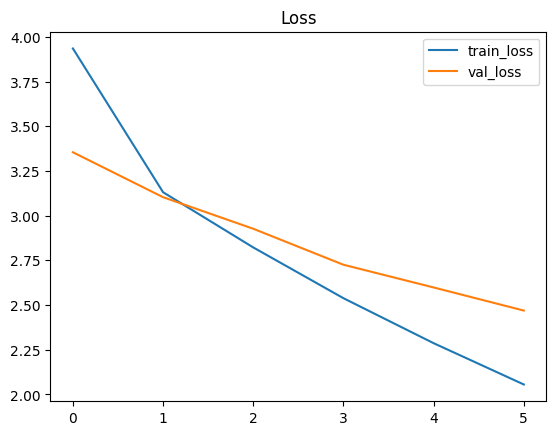

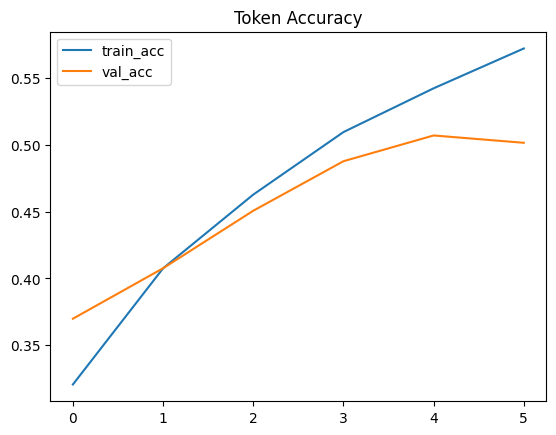

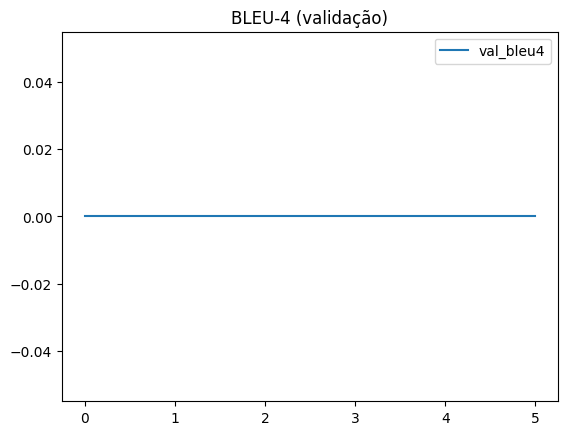

In [22]:
# Loss
plt.figure()
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

# Token Accuracy
plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Token Accuracy')
plt.legend()
plt.show()

# BLEU-4 (val)
plt.figure()
plt.plot(history['val_bleu'], label='val_bleu4')
plt.title('BLEU-4 (validação)')
plt.legend()
plt.show()

## 8) Inferência: traduzindo frases de exemplo

In [23]:
id2tgt = TGT_VOCAB.to_tokens

def translate_sentence(model, sentence_tokens, src_vocab, num_steps=NUM_STEPS, eos_idx=EOS_IDX):
    model.eval()
    with torch.no_grad():
        ids = torch.tensor(
            [ truncate_pad(src_vocab[sentence_tokens] + [src_vocab['<eos>']], num_steps, src_vocab['<pad>']) ],
            device=DEVICE
        )
        valid_len = torch.tensor([min(len(sentence_tokens)+1, num_steps)], device=DEVICE)
        out_ids = model.translate(ids, valid_len, max_len=num_steps)[0]
        if eos_idx in out_ids:
            out_ids = out_ids[:out_ids.index(eos_idx)]
        return [id2tgt(i) for i in out_ids]

examples = [
    ['go', '.'],
    ['i', 'am', 'here', '.'],
    ['she', 'is', 'a', 'student', '.'],
]
for ex in examples:
    print('SRC:', ' '.join(ex))
    print('PRED:', ' '.join(translate_sentence(model, ex, SRC_VOCAB)))
    print('---')

SRC: go .
PRED: !
---
SRC: i am here .
PRED: suis .
---
SRC: she is a student .
PRED: un <unk> .
---
